In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
from numpy.linalg import matrix_power as MP

import random
import scipy
from scipy.spatial.distance import cdist
from scipy.io import savemat, loadmat

import networkx as nx
import sys

import tensorflow as tf
from keras.callbacks import EarlyStopping

In [2]:
print(f"TF Version: {tf.__version__}")

TF Version: 2.14.0


In [3]:
X_train = np.array(loadmat('./Dataset/X_train.mat')['X'])
N, T = X_train.shape

print(N, T)

32 744


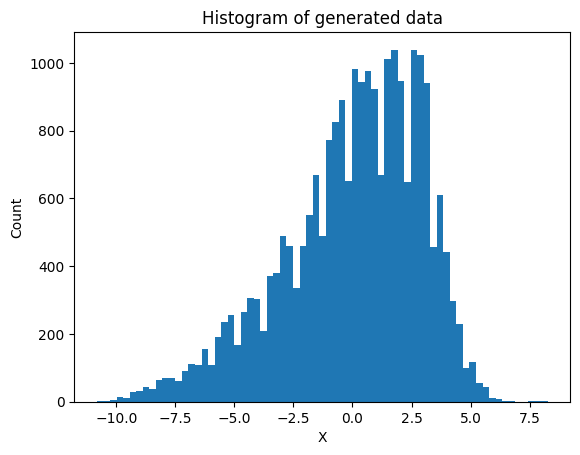

In [4]:
plt.hist(np.array(X_train).flatten(), bins = 'auto')
plt.xlabel("X")
plt.ylabel("Count")
plt.title("Histogram of generated data")
plt.show()

In [5]:
dt = np.zeros([T - 1, T])

for i in range(T - 1):
    dt[i, i] = -1
    dt[i, i - 1] = 1

d = dt.T
d = np.concatenate((d, np.zeros([T, 1])), axis = 1) 
d[T - 1, T - 1] = -1
d = d.T
d[T - 1, T - 1] = 1 
d[-1, -2] = 1
d[0, -1] = 0

d = tf.convert_to_tensor(d, dtype = "float32")

Mul = np.eye(N) - np.ones([N, N])
Mul = tf.convert_to_tensor(Mul, dtype = "float32")

In [6]:
def initial_graph(X_training, N, top_values):
    distance_matrix = cdist(X_training, X_training, metric = 'euclidean')
    
    # top_values = 6
    sorted_indices = distance_matrix.argsort(1)
    TAdj = np.zeros([N, N])
    
    for i in range(N):
        for j in range(1, top_values):
            k = sorted_indices[i][j]
            TAdj[i][k] = 1
    
    TAdj = (TAdj + TAdj.T) / 2
    TAdj = np.where(TAdj > 0.1, 1, 0)
    
    Laplacian_init = np.diag(np.sum(TAdj, 1)) - TAdj
    
    return Laplacian_init

In [7]:
coeffs = 0
psi_cost = 0
Laplacian = 0
A_transform_cost = 0

model_pred = []
loss_model = []
learned_graph = []
mse_known_list = []
mse_unknown_list = []

In [8]:
coeffs_list = np.load("./Outputs/cost_func_coeffs.npy")
print(len(coeffs_list))

80


In [9]:
# A - Target, B - Predicted
def costfunc(A, B):
    global coeffs
    global X_train
    global psi_cost
    global Laplacian
    global A_transform_cost

    B_tmp = tf.squeeze(B)
    data_fidelity = (tf.norm(tf.multiply(psi_cost, (X_train - B))) ** 2) * coeffs[0]
    smoothness = tf.linalg.trace(tf.transpose(B_tmp) @ Laplacian @ B_tmp @ A_transform_cost) * coeffs[1]
    L_cost = (tf.norm(Laplacian) ** 2) * coeffs[2]
    Z_cost = (tf.norm(A_transform_cost) ** 2) * coeffs[3]
    
    tmp = (smoothness) + (data_fidelity) + (L_cost) + (Z_cost)
    
    global loss_model
    loss_model.append(tmp)
    
    return tmp
    
def costfunc1(A, B):
    global X_train
    global psi_cost
    
    data_fidelity = (tf.norm(tf.multiply(psi_cost, (X_train - B))) ** 2)
    return (data_fidelity)

def costfunc2(A, B):
    global Laplacian
    global A_transform_cost
    
    B_tmp = tf.squeeze(B)
    smoothness = tf.linalg.trace(tf.transpose(B_tmp) @ Laplacian @ B_tmp @ A_transform_cost)
    
    return (smoothness)

def costfunc3(A, B):
    global Laplacian
    
    L_cost = (tf.norm(Laplacian) ** 2)
    
    return (L_cost)

def costfunc4(A, B):
    global A_transform_cost
    
    Z_cost = (tf.norm(A_transform_cost) ** 2)
    
    return (Z_cost)

In [10]:
def mse_unknown(A, B):
    
    global psi_cost
    psi = psi_cost
    
    psid = tf.convert_to_tensor(np.ones([N, T], dtype = float) - psi, dtype = "float32")
    mse_unk = (LA.norm(np.multiply(psid, (X_train - B))) ** 2) / np.sum(psid.numpy().flatten())
    
    global mse_unknown_list
    mse_unknown_list.append(mse_unk)
    
    return mse_unk

def mse_known(A, B):
    
    global psi_cost
    psi = psi_cost
    
    mse_kn = (LA.norm(np.multiply(psi, (X_train - B))) ** 2) / np.sum(psi.numpy().flatten())
    
    global model_pred
    model_pred.append([A.numpy(), B.numpy()])
    
    global mse_known_list
    mse_known_list.append(mse_kn)
    
    return mse_kn

In [11]:
callb = EarlyStopping(monitor = 'loss', mode = 'min', min_delta = 0.0001, verbose = 1, patience = 10)

In [12]:
def scheduler(epoch, lr):
    if epoch < 20:
        return lr
    else:
        return lr / lr_decay_factor

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [13]:
class ProposedModel(tf.keras.Model):
    
    def __init__(self, L_init, reg_init, loops_init, d_init, p_init, alpha_init, beta_init, threshold_in, **kwargs):
        super(ProposedModel, self).__init__(**kwargs)
        
        self.p1_init = tf.constant(p_init[0], shape = (1, 1), dtype = "float32")
        self.p1 = tf.Variable(initial_value = self.p1_init, trainable = True, name = "p1")
        
        self.p2_init = tf.constant(p_init[1], shape = (1, 1), dtype = "float32")
        self.p2 = tf.Variable(initial_value = self.p2_init, trainable = True, name = "p2")
        
        self.L_in = L_init
        self.preg = reg_init
        self.loops = loops_init
        self.d_int = d_init
        self.alp = alpha_init
        self.bet = beta_init
        self.threshold_init = threshold_in
        
    def data_inpainting(self, psi, Y, Lk, AAT):
        loop_b, reg = self.loops[1], self.preg

        Xk = tf.zeros_like(Y)
        Zk = -(tf.multiply(psi, Xk) - Y + (2 * reg * (Lk @ Xk @ AAT)))
        
        for i in range(loop_b):
            fdx_xk = tf.multiply(psi, Xk) - Y + (2 * reg * (Lk @ Xk @ AAT))

            # row_print = 4
            # tmp = list(zip((tf.multiply(psi, Xk) - Y)[:, row_print].numpy(), (2 * reg * (Lk @ Xk @ AAT)[:, row_print].numpy())))
            # print("\n\nStart here")
            # for k in tmp:
            #     print(k)
            
            fdx_zk = tf.multiply(psi, Zk) - Y + (2 * reg * (Lk @ Zk @ AAT))
            
            tau = tf.linalg.trace(tf.transpose(fdx_xk) @ Zk) / tf.linalg.trace(tf.transpose((Y + fdx_zk)) @ Zk)
            
            Xk_1 = Xk - (tau * Zk)

            fdx_xk_1 = tf.multiply(psi, Xk_1) - Y + (2 * reg * (Lk @ Xk_1 @ AAT))
            gamma = (tf.norm(fdx_xk_1) ** 2) / (tf.norm(fdx_xk) ** 2)

            Zk_1 = (gamma * Zk) - fdx_xk_1

            Xk = Xk_1
            Zk = Zk_1
        # print("\n\nEnds here\n\n")
        return Xk_1
    
    def graph_learning(self, X, Lk, AAT):
        loop_c, alpha, beta = self.loops[2], self.alp, self.bet
        
        # Computing the smoothness term
        X_AAT_XT = tf.matmul(X, tf.matmul(AAT, tf.transpose(X)))
        
        for i in range(loop_c):

            # Extracting the adjacency matrix from the Laplacian
            adj_i = tf.multiply(Mul, Lk)

            # Computing the gradient with respect to laplacian
            fdL_Lk = X_AAT_XT + (beta * Lk)
            
            # row_print = 4
            # print("For beta")
            # tmp = list(zip(X_AAT_XT[row_print, :].numpy(), np.array(beta * Lk)[row_print, :]))
            # for k in tmp:
            #     print(k)
            
            # Extracting the adjacency matrix from the gradient
            adj_grad = tf.multiply(Mul, fdL_Lk)
            
            # Computing the new adjacency
            # tmp = list(zip(adj_i[row_print, :].numpy(), (alpha * adj_grad)[row_print, :].numpy()))
            # print("\nFor alpha")
            # for k in tmp:
            #     print(k)
            # print("\nStart here")
            
            adj_i1 = adj_i - (alpha * adj_grad)
            
            # Avoiding any negative values
            adj_i1 = tf.nn.relu(adj_i1)

            # Computing the new laplacian
            Lk_1 = tf.linalg.diag(tf.math.reduce_sum(adj_i1, 1)) - adj_i1
            
            # Updating the laplacian
            Lk = Lk_1
        # print("\n\nEnds here\n\n")
        return Lk
    

    def call(self, y):

        psi = y[0,:,T:]
        global psi_cost
        psi_cost = psi

        psi = tf.convert_to_tensor(psi, dtype = "float32")
        
        X_in = y[0,:,:T]
        X_in = psi * tf.convert_to_tensor(X_in, dtype = "float32")
        Y = X_in
        
        d = self.d_int
        LT = tf.matmul(d, tf.transpose(d))
        LT = tf.convert_to_tensor(LT, dtype = "float32")
        
        A_transform = tf.eye(T) + (self.p1 * MP(LT, 1)) + (self.p2 * MP(LT, 2))
        AAT = A_transform
        
        global A_transform_cost
        A_transform_cost = AAT
        
        loop_a = self.loops[0]
        threshold = self.threshold_init
        Lk = self.L_in
        
        for i in range(loop_a):
            
            Xk_1 = self.data_inpainting(psi, Y, Lk, AAT)
            
            Xk_1_gt = X_in + tf.multiply((tf.ones(psi.shape) - psi), Xk_1)
            
            Lk_1 = self.graph_learning(Xk_1_gt, Lk, AAT)
            
            Adj = tf.linalg.diag(tf.linalg.diag_part(Lk_1)) - Lk_1 # Gives adjacency
            
            n = tf.math.count_nonzero(Adj, dtype="float32")
            mean = tf.math.reduce_sum(Adj) / n
            Adj = tf.math.subtract(Adj, (threshold * mean)) # Ensures the sparsity of learned graph
            
            Adj = tf.nn.relu(Adj)
            # Adj = tf.math.sign(Adj)
            
            Lk_1 = tf.linalg.diag(tf.math.reduce_sum(Adj, 1)) - Adj
            
            Lk = Lk_1
        
            global Laplacian
            Laplacian = Lk
        
        Xk_1 = self.data_inpainting(psi, Y, Lk, AAT)
        
        global learned_graph
        learned_graph.append(Lk.numpy())
        
        return tf.reshape(Xk_1, [1, N, T])

In [14]:
Lap_init = initial_graph(X_train, N, 10)

loop_a = 5
loop_b = 20 # Data Inpainting
loop_c = 10 # Graph Learning

reg_init = 1.0e-7

alpha_init = 5.0e-5
beta_init = 1.0e2

threshold_init = 0.3

no_of_psi = 10
sensing_ratio = np.arange(1.0, 81.0, 1.0) / 100.0

p_init = [10.0, 10.0]

lr_decay_factor = 1.04

all_psi = []
all_vars = []

In [15]:
for i_sen, rem in enumerate(sensing_ratio):
    
    print(f"\n\n###########################################################################################")
    print(f"################################### Sensing Ratio: {rem * 100}% ###################################")
    print(f"###########################################################################################\n\n")
    
    if i_sen == 0:
        M = int(rem * T)
        X_train_missing = np.zeros([no_of_psi, N, T])
        X_train_concatenated = np.zeros([no_of_psi, N, 2*T])
    
        for i in range(no_of_psi):
            psi_k = np.array([0] * (N * M) + [1] * (N * (T - M)))
            np.random.shuffle(psi_k)
            psi_k = psi_k.reshape([N, T])
            all_psi.append(psi_k)
            X_train_missing[i, : , : ] = X_train * psi_k
            X_train_concatenated[i, :, :] = np.concatenate((X_train_missing[i], psi_k), axis = 1)

    else:
        previous_psi = all_psi[-no_of_psi : ]
        X_train_missing = np.zeros([no_of_psi, N, T])
        X_train_concatenated = np.zeros([no_of_psi, N, 2 * T])
        
        rem_diff = int(N * (rem - sensing_ratio[i_sen - 1]) * T)
        
        for i in range(no_of_psi):
            psi_k_tmp = np.array(previous_psi[i]).flatten()
            ones_idx = np.where(psi_k_tmp == 1)
            
            ones_to_zero_idx = np.random.choice(ones_idx[0], size = rem_diff)
            psi_k_tmp[ones_to_zero_idx] = 0
            psi_k = psi_k_tmp
            
            psi_k = psi_k.reshape([N, T])
            all_psi.append(psi_k)
            X_train_missing[i, : , : ] = X_train * psi_k
            X_train_concatenated[i, :, :] = np.concatenate((X_train_missing[i], psi_k), axis = 1)
    
    coeffs = coeffs_list[i_sen, : ]
    
    sgd_optimizer = tf.keras.optimizers.SGD(learning_rate = 1.0e-2, momentum = 0.01)
    
    our_model = ProposedModel(Lap_init, reg_init, [loop_a, loop_b, loop_c], 
                              d, p_init, alpha_init, beta_init, threshold_init, name = 'our')
    our_model.compile(optimizer = sgd_optimizer, loss = costfunc,
                      metrics = [mse_known, mse_unknown], run_eagerly=True)
    
    our_model.fit(X_train_concatenated, X_train_missing, epochs = 30, 
                  callbacks = [lr_scheduler], batch_size = 1)
    
    var = our_model.variables
    var_lst = []
    for v in var:
        var_lst.append(v.numpy()[0, 0])
    print(f"\nFilter Coefficients:", var_lst)
    all_vars.append(var_lst)



###########################################################################################
################################### Sensing Ratio: 1.0% ###################################
###########################################################################################




Epoch 1/30
10/10 [==============================] - 15s 1s/step - loss: 14.4870 - mse_known: 2.9769e-06 - mse_unknown: 0.4937 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 14.1378 - mse_known: 2.8719e-06 - mse_unknown: 0.4926 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 13.7971 - mse_known: 2.7709e-06 - mse_unknown: 0.4917 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 15s 1s/step - loss: 13.4652 - mse_known: 2.6730e-06 - mse_unknown: 0.4907 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 13.1410 - mse_known: 2.5786e-06 - mse_unknown: 0.4896 - lr: 0.0100
Epoch 6/30
10/10 [==============================] - 14s 1s/step - loss: 12.8248 - mse_known: 2.4872e-06 - mse_unknown: 0.4884 - lr: 0.0100
Epoch 7/30
10/10 [==============================] - 14s 1s/step - loss: 12.5164 - mse_known: 2.3994e-06 - mse_unknown: 0.4871 - lr: 0.0100
Epoch 8/30
10/10 [=========


Filter Coefficients: [8.3517, 5.801799]


###########################################################################################
################################### Sensing Ratio: 2.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 14.4199 - mse_known: 2.9572e-06 - mse_unknown: 0.4472 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 14.0730 - mse_known: 2.8559e-06 - mse_unknown: 0.4463 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 13.7347 - mse_known: 2.7587e-06 - mse_unknown: 0.4455 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 13.4047 - mse_known: 2.6660e-06 - mse_unknown: 0.4449 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 13.0827 - mse_known: 2.5730e-06 - mse_unknown: 0.44


Filter Coefficients: [8.358205, 5.8142004]


###########################################################################################
################################### Sensing Ratio: 3.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 14.3496 - mse_known: 2.9215e-06 - mse_unknown: 0.4499 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 14.0049 - mse_known: 2.8204e-06 - mse_unknown: 0.4487 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 13.6686 - mse_known: 2.7241e-06 - mse_unknown: 0.4478 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 13.3406 - mse_known: 2.6305e-06 - mse_unknown: 0.4468 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 13.0206 - mse_known: 2.5409e-06 - mse_unknown: 0


Filter Coefficients: [8.365, 5.8268986]


###########################################################################################
################################### Sensing Ratio: 4.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 14.2822 - mse_known: 2.8947e-06 - mse_unknown: 0.4699 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 13.9398 - mse_known: 2.7944e-06 - mse_unknown: 0.4687 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 13.6058 - mse_known: 2.6977e-06 - mse_unknown: 0.4671 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 13.2799 - mse_known: 2.6042e-06 - mse_unknown: 0.4657 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 15s 1s/step - loss: 12.9621 - mse_known: 2.5135e-06 - mse_unknown: 0.46


Filter Coefficients: [8.371551, 5.839122]


###########################################################################################
################################### Sensing Ratio: 5.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 14.2155 - mse_known: 2.8703e-06 - mse_unknown: 0.4735 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 13.8751 - mse_known: 2.7712e-06 - mse_unknown: 0.4723 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 13.5432 - mse_known: 2.6751e-06 - mse_unknown: 0.4711 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 13.2199 - mse_known: 2.5823e-06 - mse_unknown: 0.4696 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 17s 2s/step - loss: 12.9042 - mse_known: 2.4927e-06 - mse_unknown: 0.


Filter Coefficients: [8.378041, 5.850911]


###########################################################################################
################################### Sensing Ratio: 6.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 14.1363 - mse_known: 2.8300e-06 - mse_unknown: 0.4793 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 13.7987 - mse_known: 2.7322e-06 - mse_unknown: 0.4780 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 13.4697 - mse_known: 2.6379e-06 - mse_unknown: 0.4767 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 13.1484 - mse_known: 2.5466e-06 - mse_unknown: 0.4754 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 12.8351 - mse_known: 2.4582e-06 - mse_unknown: 0.


Filter Coefficients: [8.385792, 5.865807]


###########################################################################################
################################### Sensing Ratio: 7.000000000000001% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 14.0665 - mse_known: 2.8049e-06 - mse_unknown: 0.4955 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 13.7312 - mse_known: 2.7082e-06 - mse_unknown: 0.4942 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 15s 1s/step - loss: 13.4039 - mse_known: 2.6148e-06 - mse_unknown: 0.4930 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 15s 1s/step - loss: 13.0846 - mse_known: 2.5242e-06 - mse_unknown: 0.4916 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 15s 1s/step - loss: 12.7733 - mse_known: 2.4370e-06 - m


Filter Coefficients: [8.392759, 5.8782806]


###########################################################################################
################################### Sensing Ratio: 8.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 13.9955 - mse_known: 2.7776e-06 - mse_unknown: 0.5031 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 13.6623 - mse_known: 2.6818e-06 - mse_unknown: 0.5018 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 13.3373 - mse_known: 2.5895e-06 - mse_unknown: 0.5004 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 13.0204 - mse_known: 2.5003e-06 - mse_unknown: 0.4991 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 15s 1s/step - loss: 12.7112 - mse_known: 2.4142e-06 - mse_unknown: 0


Filter Coefficients: [8.400097, 5.8918905]


###########################################################################################
################################### Sensing Ratio: 9.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 15s 1s/step - loss: 13.9239 - mse_known: 2.7461e-06 - mse_unknown: 0.5117 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 13.5935 - mse_known: 2.6520e-06 - mse_unknown: 0.5103 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 13.2712 - mse_known: 2.5615e-06 - mse_unknown: 0.5088 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 12.9561 - mse_known: 2.4731e-06 - mse_unknown: 0.5073 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 12.6490 - mse_known: 2.3881e-06 - mse_unknown: 0


Filter Coefficients: [8.407407, 5.90447]


###########################################################################################
################################### Sensing Ratio: 10.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 15s 1s/step - loss: 13.8539 - mse_known: 2.7203e-06 - mse_unknown: 0.5150 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 13.5255 - mse_known: 2.6273e-06 - mse_unknown: 0.5136 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 13.2049 - mse_known: 2.5374e-06 - mse_unknown: 0.5122 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 12.8922 - mse_known: 2.4504e-06 - mse_unknown: 0.5106 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 15s 1s/step - loss: 12.5872 - mse_known: 2.3664e-06 - mse_unknown: 0.


Filter Coefficients: [8.414457, 5.917174]


###########################################################################################
################################### Sensing Ratio: 11.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 13.7782 - mse_known: 2.6868e-06 - mse_unknown: 0.5146 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 13.4523 - mse_known: 2.5953e-06 - mse_unknown: 0.5132 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 13.1343 - mse_known: 2.5066e-06 - mse_unknown: 0.5117 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 12.8240 - mse_known: 2.4211e-06 - mse_unknown: 0.5102 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 12.5212 - mse_known: 2.3385e-06 - mse_unknown: 0


Filter Coefficients: [8.42228, 5.9309993]


###########################################################################################
################################### Sensing Ratio: 12.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 13.7138 - mse_known: 2.6660e-06 - mse_unknown: 0.5237 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 13.3899 - mse_known: 2.5755e-06 - mse_unknown: 0.5222 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 15s 1s/step - loss: 13.0740 - mse_known: 2.4880e-06 - mse_unknown: 0.5208 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 15s 1s/step - loss: 12.7657 - mse_known: 2.4033e-06 - mse_unknown: 0.5194 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 15s 1s/step - loss: 12.4648 - mse_known: 2.3216e-06 - mse_unknown: 0


Filter Coefficients: [8.428832, 5.9427447]


###########################################################################################
################################### Sensing Ratio: 13.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 13.6375 - mse_known: 2.6312e-06 - mse_unknown: 0.5278 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 13.3161 - mse_known: 2.5422e-06 - mse_unknown: 0.5265 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 13.0025 - mse_known: 2.4558e-06 - mse_unknown: 0.5252 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 12.6967 - mse_known: 2.3729e-06 - mse_unknown: 0.5240 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 12.3981 - mse_known: 2.2924e-06 - mse_unknown: 


Filter Coefficients: [8.436525, 5.9565444]


###########################################################################################
################################### Sensing Ratio: 14.000000000000002% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 13.5754 - mse_known: 2.6042e-06 - mse_unknown: 0.5320 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 13.2560 - mse_known: 2.5162e-06 - mse_unknown: 0.5309 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 12.9446 - mse_known: 2.4315e-06 - mse_unknown: 0.5296 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 12.6405 - mse_known: 2.3496e-06 - mse_unknown: 0.5282 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 12.3437 - mse_known: 2.2697e-06 -


Filter Coefficients: [8.442606, 5.9681187]


###########################################################################################
################################### Sensing Ratio: 15.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 13.4976 - mse_known: 2.5630e-06 - mse_unknown: 0.5357 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 13.1807 - mse_known: 2.4773e-06 - mse_unknown: 0.5347 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 12.8714 - mse_known: 2.3936e-06 - mse_unknown: 0.5336 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 15s 1s/step - loss: 12.5696 - mse_known: 2.3131e-06 - mse_unknown: 0.5326 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 12.2750 - mse_known: 2.2353e-06 - mse_unknown: 


Filter Coefficients: [8.450091, 5.982527]


###########################################################################################
################################### Sensing Ratio: 16.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 13.4384 - mse_known: 2.5401e-06 - mse_unknown: 0.5352 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 13.1232 - mse_known: 2.4550e-06 - mse_unknown: 0.5343 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 12.8157 - mse_known: 2.3723e-06 - mse_unknown: 0.5333 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 12.5153 - mse_known: 2.2922e-06 - mse_unknown: 0.5322 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 12.2223 - mse_known: 2.2151e-06 - mse_unknown: 0


Filter Coefficients: [8.456509, 5.9924583]


###########################################################################################
################################### Sensing Ratio: 17.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 13.3765 - mse_known: 2.5126e-06 - mse_unknown: 0.5400 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 13.0632 - mse_known: 2.4285e-06 - mse_unknown: 0.5390 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 12.7574 - mse_known: 2.3471e-06 - mse_unknown: 0.5380 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 12.4590 - mse_known: 2.2686e-06 - mse_unknown: 0.5371 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 12.1680 - mse_known: 2.1930e-06 - mse_unknown: 


Filter Coefficients: [8.462502, 6.0035305]


###########################################################################################
################################### Sensing Ratio: 18.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 13.3167 - mse_known: 2.4902e-06 - mse_unknown: 0.5507 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 13.0052 - mse_known: 2.4073e-06 - mse_unknown: 0.5499 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 12.7015 - mse_known: 2.3271e-06 - mse_unknown: 0.5487 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 12.4044 - mse_known: 2.2490e-06 - mse_unknown: 0.5480 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 12.1149 - mse_known: 2.1742e-06 - mse_unknown: 


Filter Coefficients: [8.468984, 6.0137944]


###########################################################################################
################################### Sensing Ratio: 19.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 13.2589 - mse_known: 2.4635e-06 - mse_unknown: 0.5537 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 12.9488 - mse_known: 2.3811e-06 - mse_unknown: 0.5529 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 12.6463 - mse_known: 2.3016e-06 - mse_unknown: 0.5521 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 15s 1s/step - loss: 12.3512 - mse_known: 2.2253e-06 - mse_unknown: 0.5514 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 12.0633 - mse_known: 2.1512e-06 - mse_unknown: 


Filter Coefficients: [8.475142, 6.023821]


###########################################################################################
################################### Sensing Ratio: 20.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 13.1884 - mse_known: 2.4260e-06 - mse_unknown: 0.5602 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 12.8807 - mse_known: 2.3452e-06 - mse_unknown: 0.5594 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 12.5805 - mse_known: 2.2674e-06 - mse_unknown: 0.5587 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 12.2873 - mse_known: 2.1921e-06 - mse_unknown: 0.5580 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 12.0017 - mse_known: 2.1194e-06 - mse_unknown: 0


Filter Coefficients: [8.482299, 6.036373]


###########################################################################################
################################### Sensing Ratio: 21.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 13.1280 - mse_known: 2.3956e-06 - mse_unknown: 0.5693 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 12.8217 - mse_known: 2.3153e-06 - mse_unknown: 0.5687 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 12.5233 - mse_known: 2.2392e-06 - mse_unknown: 0.5679 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 12.2319 - mse_known: 2.1654e-06 - mse_unknown: 0.5673 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 11.9476 - mse_known: 2.0934e-06 - mse_unknown: 0


Filter Coefficients: [8.489148, 6.046811]


###########################################################################################
################################### Sensing Ratio: 22.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 13.0729 - mse_known: 2.3702e-06 - mse_unknown: 0.5694 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 12.7687 - mse_known: 2.2920e-06 - mse_unknown: 0.5686 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 12.4714 - mse_known: 2.2163e-06 - mse_unknown: 0.5683 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 12.1814 - mse_known: 2.1432e-06 - mse_unknown: 0.5677 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 11.8987 - mse_known: 2.0726e-06 - mse_unknown: 0


Filter Coefficients: [8.494651, 6.055466]


###########################################################################################
################################### Sensing Ratio: 23.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 51.7147 - mse_known: 2.2714e-06 - mse_unknown: 0.5711 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 49.2519 - mse_known: 2.0573e-06 - mse_unknown: 0.5697 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 46.9012 - mse_known: 1.8611e-06 - mse_unknown: 0.5678 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 44.6502 - mse_known: 1.6822e-06 - mse_unknown: 0.5656 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 15s 1s/step - loss: 42.4952 - mse_known: 1.5185e-06 - mse_unknown: 0


Filter Coefficients: [4.4406986, 0.83086354]


###########################################################################################
################################### Sensing Ratio: 24.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 12.9430 - mse_known: 2.3010e-06 - mse_unknown: 0.5735 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 12.6421 - mse_known: 2.2253e-06 - mse_unknown: 0.5732 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 12.3487 - mse_known: 2.1527e-06 - mse_unknown: 0.5729 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 12.0622 - mse_known: 2.0815e-06 - mse_unknown: 0.5725 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 11.7827 - mse_known: 2.0130e-06 - mse_unknown


Filter Coefficients: [8.508363, 6.077692]


###########################################################################################
################################### Sensing Ratio: 25.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 12.8833 - mse_known: 2.2705e-06 - mse_unknown: 0.5752 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 12.5847 - mse_known: 2.1962e-06 - mse_unknown: 0.5748 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 12.2928 - mse_known: 2.1245e-06 - mse_unknown: 0.5745 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 12.0084 - mse_known: 2.0548e-06 - mse_unknown: 0.5741 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 16s 2s/step - loss: 11.7305 - mse_known: 1.9875e-06 - mse_unknown: 0


Filter Coefficients: [8.514445, 6.0883126]


###########################################################################################
################################### Sensing Ratio: 26.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 49.8869 - mse_known: 2.1780e-06 - mse_unknown: 0.5853 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 47.5897 - mse_known: 1.9797e-06 - mse_unknown: 0.5845 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 45.3856 - mse_known: 1.7980e-06 - mse_unknown: 0.5830 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 43.2757 - mse_known: 1.6299e-06 - mse_unknown: 0.5819 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 41.2504 - mse_known: 1.4757e-06 - mse_unknown: 


Filter Coefficients: [4.566954, 1.1106136]


###########################################################################################
################################### Sensing Ratio: 27.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 49.2852 - mse_known: 2.1476e-06 - mse_unknown: 0.5845 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 47.0308 - mse_known: 1.9533e-06 - mse_unknown: 0.5837 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 44.8763 - mse_known: 1.7747e-06 - mse_unknown: 0.5828 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 42.8082 - mse_known: 1.6117e-06 - mse_unknown: 0.5819 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 40.8237 - mse_known: 1.4616e-06 - mse_unknown: 


Filter Coefficients: [4.609628, 1.2086251]


###########################################################################################
################################### Sensing Ratio: 28.000000000000004% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 48.6363 - mse_known: 2.1098e-06 - mse_unknown: 0.6010 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 46.4363 - mse_known: 1.9211e-06 - mse_unknown: 0.6002 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 44.3290 - mse_known: 1.7476e-06 - mse_unknown: 0.5994 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 42.3070 - mse_known: 1.5886e-06 - mse_unknown: 0.5981 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 40.3816 - mse_known: 1.4426e-06 -


Filter Coefficients: [4.6566005, 1.3062426]


###########################################################################################
################################### Sensing Ratio: 28.999999999999996% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 48.1029 - mse_known: 2.0872e-06 - mse_unknown: 0.6104 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 45.9545 - mse_known: 1.9023e-06 - mse_unknown: 0.6098 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 43.8902 - mse_known: 1.7325e-06 - mse_unknown: 0.6089 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 41.9124 - mse_known: 1.5771e-06 - mse_unknown: 0.6079 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 40.0169 - mse_known: 1.4335e-06 


Filter Coefficients: [4.6943893, 1.3803743]


###########################################################################################
################################### Sensing Ratio: 30.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 47.5432 - mse_known: 2.0566e-06 - mse_unknown: 0.6233 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 45.4411 - mse_known: 1.8770e-06 - mse_unknown: 0.6224 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 43.4167 - mse_known: 1.7102e-06 - mse_unknown: 0.6213 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 41.4751 - mse_known: 1.5578e-06 - mse_unknown: 0.6204 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 39.6194 - mse_known: 1.4175e-06 - mse_unknown:


Filter Coefficients: [4.73945, 1.4622667]


###########################################################################################
################################### Sensing Ratio: 31.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 46.9542 - mse_known: 2.0204e-06 - mse_unknown: 0.6342 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 44.8972 - mse_known: 1.8455e-06 - mse_unknown: 0.6332 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 42.9188 - mse_known: 1.6843e-06 - mse_unknown: 0.6321 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 41.0243 - mse_known: 1.5359e-06 - mse_unknown: 0.6311 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 39.2019 - mse_known: 1.3994e-06 - mse_unknown: 0


Filter Coefficients: [4.787139, 1.548796]


###########################################################################################
################################### Sensing Ratio: 32.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 46.4192 - mse_known: 1.9942e-06 - mse_unknown: 0.6387 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 44.4064 - mse_known: 1.8237e-06 - mse_unknown: 0.6379 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 42.4751 - mse_known: 1.6670e-06 - mse_unknown: 0.6370 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 40.6182 - mse_known: 1.5215e-06 - mse_unknown: 0.6359 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 38.8366 - mse_known: 1.3870e-06 - mse_unknown: 0


Filter Coefficients: [4.8319597, 1.632014]


###########################################################################################
################################### Sensing Ratio: 33.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 45.8755 - mse_known: 1.9684e-06 - mse_unknown: 0.6524 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 43.9054 - mse_known: 1.8012e-06 - mse_unknown: 0.6514 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 42.0092 - mse_known: 1.6473e-06 - mse_unknown: 0.6503 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 40.1914 - mse_known: 1.5050e-06 - mse_unknown: 0.6490 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 38.4485 - mse_known: 1.3742e-06 - mse_unknown: 


Filter Coefficients: [4.875748, 1.7153342]


###########################################################################################
################################### Sensing Ratio: 34.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 45.3218 - mse_known: 1.9328e-06 - mse_unknown: 0.6598 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 43.3960 - mse_known: 1.7708e-06 - mse_unknown: 0.6589 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 41.5491 - mse_known: 1.6219e-06 - mse_unknown: 0.6580 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 39.7677 - mse_known: 1.4830e-06 - mse_unknown: 0.6567 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 38.0523 - mse_known: 1.3557e-06 - mse_unknown: 


Filter Coefficients: [4.9262033, 1.7914004]


###########################################################################################
################################### Sensing Ratio: 35.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 44.7945 - mse_known: 1.9003e-06 - mse_unknown: 0.6683 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 42.9106 - mse_known: 1.7434e-06 - mse_unknown: 0.6673 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 41.0978 - mse_known: 1.5968e-06 - mse_unknown: 0.6663 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 39.3583 - mse_known: 1.4624e-06 - mse_unknown: 0.6651 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 15s 1s/step - loss: 37.6852 - mse_known: 1.3381e-06 - mse_unknown:


Filter Coefficients: [4.970886, 1.8643674]


###########################################################################################
################################### Sensing Ratio: 36.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 15s 1s/step - loss: 44.3261 - mse_known: 1.8722e-06 - mse_unknown: 0.6848 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 15s 1s/step - loss: 42.4752 - mse_known: 1.7181e-06 - mse_unknown: 0.6837 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 15s 1s/step - loss: 40.6966 - mse_known: 1.5764e-06 - mse_unknown: 0.6827 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 38.9858 - mse_known: 1.4443e-06 - mse_unknown: 0.6813 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 37.3322 - mse_known: 1.3217e-06 - mse_unknown: 


Filter Coefficients: [5.009054, 1.9247053]


###########################################################################################
################################### Sensing Ratio: 37.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 43.8155 - mse_known: 1.8413e-06 - mse_unknown: 0.6998 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 42.0030 - mse_known: 1.6915e-06 - mse_unknown: 0.6990 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 40.2614 - mse_known: 1.5533e-06 - mse_unknown: 0.6978 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 38.5853 - mse_known: 1.4245e-06 - mse_unknown: 0.6966 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 36.9701 - mse_known: 1.3059e-06 - mse_unknown: 


Filter Coefficients: [5.051513, 1.982054]


###########################################################################################
################################### Sensing Ratio: 38.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 43.4168 - mse_known: 1.8220e-06 - mse_unknown: 0.7158 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 41.6276 - mse_known: 1.6735e-06 - mse_unknown: 0.7150 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 39.9079 - mse_known: 1.5376e-06 - mse_unknown: 0.7138 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 15s 1s/step - loss: 38.2566 - mse_known: 1.4113e-06 - mse_unknown: 0.7128 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 15s 1s/step - loss: 36.6599 - mse_known: 1.2940e-06 - mse_unknown: 0


Filter Coefficients: [5.0980654, 2.0419111]


###########################################################################################
################################### Sensing Ratio: 39.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 42.9616 - mse_known: 1.7982e-06 - mse_unknown: 0.7317 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 41.2049 - mse_known: 1.6537e-06 - mse_unknown: 0.7305 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 39.5144 - mse_known: 1.5201e-06 - mse_unknown: 0.7295 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 37.8891 - mse_known: 1.3956e-06 - mse_unknown: 0.7284 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 36.3267 - mse_known: 1.2818e-06 - mse_unknown:


Filter Coefficients: [5.1394744, 2.1069922]


###########################################################################################
################################### Sensing Ratio: 40.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 42.5546 - mse_known: 1.7745e-06 - mse_unknown: 0.7530 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 40.8201 - mse_known: 1.6334e-06 - mse_unknown: 0.7519 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 39.1532 - mse_known: 1.5008e-06 - mse_unknown: 0.7506 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 15s 1s/step - loss: 37.5533 - mse_known: 1.3803e-06 - mse_unknown: 0.7491 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 15s 1s/step - loss: 36.0129 - mse_known: 1.2674e-06 - mse_unknown:


Filter Coefficients: [5.187905, 2.16331]


###########################################################################################
################################### Sensing Ratio: 41.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 42.0183 - mse_known: 1.7356e-06 - mse_unknown: 0.7718 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 40.3217 - mse_known: 1.5984e-06 - mse_unknown: 0.7704 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 15s 1s/step - loss: 38.6941 - mse_known: 1.4717e-06 - mse_unknown: 0.7686 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 37.1278 - mse_known: 1.3536e-06 - mse_unknown: 0.7670 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 35.6254 - mse_known: 1.2449e-06 - mse_unknown: 0.


Filter Coefficients: [5.238191, 2.2214944]


###########################################################################################
################################### Sensing Ratio: 42.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 41.5871 - mse_known: 1.7129e-06 - mse_unknown: 0.7942 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 39.9172 - mse_known: 1.5779e-06 - mse_unknown: 0.7928 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 38.3134 - mse_known: 1.4533e-06 - mse_unknown: 0.7911 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 36.7713 - mse_known: 1.3379e-06 - mse_unknown: 0.7894 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 35.2891 - mse_known: 1.2308e-06 - mse_unknown: 


Filter Coefficients: [5.2835374, 2.2606876]


###########################################################################################
################################### Sensing Ratio: 43.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 41.2215 - mse_known: 1.6927e-06 - mse_unknown: 0.8127 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 15s 1s/step - loss: 39.5712 - mse_known: 1.5603e-06 - mse_unknown: 0.8112 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 37.9875 - mse_known: 1.4385e-06 - mse_unknown: 0.8094 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 36.4652 - mse_known: 1.3241e-06 - mse_unknown: 0.8077 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 35.0014 - mse_known: 1.2192e-06 - mse_unknown:


Filter Coefficients: [5.3301277, 2.3259256]


###########################################################################################
################################### Sensing Ratio: 44.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 40.8343 - mse_known: 1.6614e-06 - mse_unknown: 0.8320 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 39.2104 - mse_known: 1.5320e-06 - mse_unknown: 0.8302 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 37.6509 - mse_known: 1.4135e-06 - mse_unknown: 0.8285 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 36.1490 - mse_known: 1.3021e-06 - mse_unknown: 0.8266 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 34.7053 - mse_known: 1.1988e-06 - mse_unknown:


Filter Coefficients: [5.3662214, 2.3432002]


###########################################################################################
################################### Sensing Ratio: 45.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 40.2998 - mse_known: 1.6177e-06 - mse_unknown: 0.8524 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 38.7096 - mse_known: 1.4934e-06 - mse_unknown: 0.8505 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 37.1813 - mse_known: 1.3787e-06 - mse_unknown: 0.8485 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 35.7137 - mse_known: 1.2718e-06 - mse_unknown: 0.8463 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 34.3004 - mse_known: 1.1721e-06 - mse_unknown:


Filter Coefficients: [5.4274635, 2.407378]


###########################################################################################
################################### Sensing Ratio: 46.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 39.9436 - mse_known: 1.5947e-06 - mse_unknown: 0.8752 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 38.3736 - mse_known: 1.4735e-06 - mse_unknown: 0.8735 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 36.8640 - mse_known: 1.3595e-06 - mse_unknown: 0.8716 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 35.4131 - mse_known: 1.2552e-06 - mse_unknown: 0.8694 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 34.0169 - mse_known: 1.1573e-06 - mse_unknown: 


Filter Coefficients: [5.475921, 2.4630685]


###########################################################################################
################################### Sensing Ratio: 47.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 39.5799 - mse_known: 1.5747e-06 - mse_unknown: 0.8969 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 38.0302 - mse_known: 1.4552e-06 - mse_unknown: 0.8948 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 36.5408 - mse_known: 1.3432e-06 - mse_unknown: 0.8930 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 35.1061 - mse_known: 1.2401e-06 - mse_unknown: 0.8909 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 33.7284 - mse_known: 1.1446e-06 - mse_unknown: 


Filter Coefficients: [5.5222964, 2.5014005]


###########################################################################################
################################### Sensing Ratio: 48.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 15s 1s/step - loss: 39.1620 - mse_known: 1.5414e-06 - mse_unknown: 0.9219 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 37.6371 - mse_known: 1.4253e-06 - mse_unknown: 0.9200 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 36.1696 - mse_known: 1.3171e-06 - mse_unknown: 0.9178 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 34.7577 - mse_known: 1.2163e-06 - mse_unknown: 0.9157 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 33.4012 - mse_known: 1.1231e-06 - mse_unknown:


Filter Coefficients: [5.571188, 2.5540397]


###########################################################################################
################################### Sensing Ratio: 49.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 38.9236 - mse_known: 1.5292e-06 - mse_unknown: 0.9471 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 15s 1s/step - loss: 37.4072 - mse_known: 1.4131e-06 - mse_unknown: 0.9451 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 15s 2s/step - loss: 35.9481 - mse_known: 1.3058e-06 - mse_unknown: 0.9429 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 34.5462 - mse_known: 1.2068e-06 - mse_unknown: 0.9405 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 33.1967 - mse_known: 1.1138e-06 - mse_unknown: 


Filter Coefficients: [5.6091785, 2.555123]


###########################################################################################
################################### Sensing Ratio: 50.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 38.5459 - mse_known: 1.5053e-06 - mse_unknown: 0.9699 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 15s 2s/step - loss: 37.0436 - mse_known: 1.3918e-06 - mse_unknown: 0.9675 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 15s 1s/step - loss: 35.6081 - mse_known: 1.2858e-06 - mse_unknown: 0.9650 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 16s 2s/step - loss: 34.2267 - mse_known: 1.1894e-06 - mse_unknown: 0.9626 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 15s 1s/step - loss: 32.8993 - mse_known: 1.0992e-06 - mse_unknown: 


Filter Coefficients: [5.6497083, 2.5885766]


###########################################################################################
################################### Sensing Ratio: 51.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 15s 2s/step - loss: 38.1327 - mse_known: 1.4773e-06 - mse_unknown: 0.9995 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 36.6650 - mse_known: 1.3678e-06 - mse_unknown: 0.9974 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 35.2433 - mse_known: 1.2663e-06 - mse_unknown: 0.9944 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 33.8848 - mse_known: 1.1717e-06 - mse_unknown: 0.9916 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 32.5775 - mse_known: 1.0837e-06 - mse_unknown:


Filter Coefficients: [5.7026277, 2.6423438]


###########################################################################################
################################### Sensing Ratio: 52.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 37.7727 - mse_known: 1.4656e-06 - mse_unknown: 1.0292 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 36.3146 - mse_known: 1.3570e-06 - mse_unknown: 1.0267 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 34.9183 - mse_known: 1.2565e-06 - mse_unknown: 1.0234 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 33.5787 - mse_known: 1.1636e-06 - mse_unknown: 1.0204 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 32.2897 - mse_known: 1.0767e-06 - mse_unknown:


Filter Coefficients: [5.747124, 2.6759114]


###########################################################################################
################################### Sensing Ratio: 53.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 37.5471 - mse_known: 1.4668e-06 - mse_unknown: 1.0603 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 36.1062 - mse_known: 1.3584e-06 - mse_unknown: 1.0575 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 34.7197 - mse_known: 1.2584e-06 - mse_unknown: 1.0545 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 15s 1s/step - loss: 33.3869 - mse_known: 1.1644e-06 - mse_unknown: 1.0513 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 15s 1s/step - loss: 32.1030 - mse_known: 1.0775e-06 - mse_unknown: 


Filter Coefficients: [5.787375, 2.6781762]


###########################################################################################
################################### Sensing Ratio: 54.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 15s 1s/step - loss: 37.3054 - mse_known: 1.4667e-06 - mse_unknown: 1.0902 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 15s 2s/step - loss: 35.8682 - mse_known: 1.3579e-06 - mse_unknown: 1.0867 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 15s 1s/step - loss: 34.4862 - mse_known: 1.2564e-06 - mse_unknown: 1.0835 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 33.1623 - mse_known: 1.1629e-06 - mse_unknown: 1.0802 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 31.8840 - mse_known: 1.0759e-06 - mse_unknown: 


Filter Coefficients: [5.827334, 2.6841505]


###########################################################################################
################################### Sensing Ratio: 55.00000000000001% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 37.0880 - mse_known: 1.4614e-06 - mse_unknown: 1.1198 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 35.6493 - mse_known: 1.3517e-06 - mse_unknown: 1.1170 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 34.2721 - mse_known: 1.2512e-06 - mse_unknown: 1.1132 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 32.9523 - mse_known: 1.1573e-06 - mse_unknown: 1.1098 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 31.6827 - mse_known: 1.0700e-06 - 


Filter Coefficients: [5.858137, 2.668868]


###########################################################################################
################################### Sensing Ratio: 56.00000000000001% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 16s 2s/step - loss: 36.9562 - mse_known: 1.4934e-06 - mse_unknown: 1.1503 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 16s 2s/step - loss: 35.5188 - mse_known: 1.3814e-06 - mse_unknown: 1.1467 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 16s 2s/step - loss: 34.1416 - mse_known: 1.2765e-06 - mse_unknown: 1.1432 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 15s 2s/step - loss: 32.8191 - mse_known: 1.1810e-06 - mse_unknown: 1.1396 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 15s 2s/step - loss: 31.5490 - mse_known: 1.0914e-06 - m


Filter Coefficients: [5.898504, 2.6834233]


###########################################################################################
################################### Sensing Ratio: 56.99999999999999% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 16s 2s/step - loss: 36.7015 - mse_known: 1.4755e-06 - mse_unknown: 1.1847 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 16s 2s/step - loss: 35.2755 - mse_known: 1.3665e-06 - mse_unknown: 1.1809 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 16s 2s/step - loss: 33.9021 - mse_known: 1.2618e-06 - mse_unknown: 1.1767 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 16s 2s/step - loss: 32.5873 - mse_known: 1.1675e-06 - mse_unknown: 1.1726 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 16s 2s/step - loss: 31.3262 - mse_known: 1.0791e-06 - 


Filter Coefficients: [5.9414907, 2.690837]


###########################################################################################
################################### Sensing Ratio: 57.99999999999999% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 36.5478 - mse_known: 1.5186e-06 - mse_unknown: 1.2177 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 35.1170 - mse_known: 1.4053e-06 - mse_unknown: 1.2136 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 33.7493 - mse_known: 1.2987e-06 - mse_unknown: 1.2092 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 32.4343 - mse_known: 1.2002e-06 - mse_unknown: 1.2051 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 31.1745 - mse_known: 1.1100e-06 - 


Filter Coefficients: [5.9873624, 2.67645]


###########################################################################################
################################### Sensing Ratio: 59.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 36.4148 - mse_known: 1.6023e-06 - mse_unknown: 1.2458 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 35.0073 - mse_known: 1.4816e-06 - mse_unknown: 1.2426 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 33.6421 - mse_known: 1.3703e-06 - mse_unknown: 1.2385 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 32.3284 - mse_known: 1.2666e-06 - mse_unknown: 1.2335 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 31.0628 - mse_known: 1.1707e-06 - mse_unknown: 1


Filter Coefficients: [6.0178113, 2.6601622]


###########################################################################################
################################### Sensing Ratio: 60.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 36.1350 - mse_known: 1.6564e-06 - mse_unknown: 1.2874 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 34.7390 - mse_known: 1.5379e-06 - mse_unknown: 1.2848 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 33.3910 - mse_known: 1.4231e-06 - mse_unknown: 1.2796 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 32.0890 - mse_known: 1.3143e-06 - mse_unknown: 1.2753 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 30.8400 - mse_known: 1.2160e-06 - mse_unknown:


Filter Coefficients: [6.055284, 2.671076]


###########################################################################################
################################### Sensing Ratio: 61.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 36.0902 - mse_known: 1.7653e-06 - mse_unknown: 1.3179 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 34.6660 - mse_known: 1.6355e-06 - mse_unknown: 1.3133 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 33.2941 - mse_known: 1.5131e-06 - mse_unknown: 1.3084 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 31.9885 - mse_known: 1.3966e-06 - mse_unknown: 1.3037 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 30.7327 - mse_known: 1.2897e-06 - mse_unknown: 1


Filter Coefficients: [6.07575, 2.640309]


###########################################################################################
################################### Sensing Ratio: 62.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 36.0123 - mse_known: 1.8792e-06 - mse_unknown: 1.3600 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 34.5849 - mse_known: 1.7342e-06 - mse_unknown: 1.3535 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 33.2246 - mse_known: 1.6099e-06 - mse_unknown: 1.3485 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 31.9157 - mse_known: 1.4892e-06 - mse_unknown: 1.3440 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 30.6570 - mse_known: 1.3783e-06 - mse_unknown: 1.


Filter Coefficients: [6.102517, 2.6328456]


###########################################################################################
################################### Sensing Ratio: 63.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 35.9612 - mse_known: 2.0003e-06 - mse_unknown: 1.3894 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 34.5335 - mse_known: 1.8504e-06 - mse_unknown: 1.3836 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 33.1597 - mse_known: 1.7150e-06 - mse_unknown: 1.3784 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 31.8355 - mse_known: 1.5852e-06 - mse_unknown: 1.3724 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 30.5729 - mse_known: 1.4669e-06 - mse_unknown: 


Filter Coefficients: [6.1293573, 2.6006148]


###########################################################################################
################################### Sensing Ratio: 64.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 36.0323 - mse_known: 2.1685e-06 - mse_unknown: 1.4343 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 34.5793 - mse_known: 2.0078e-06 - mse_unknown: 1.4289 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 33.1899 - mse_known: 1.8519e-06 - mse_unknown: 1.4221 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 31.8530 - mse_known: 1.7068e-06 - mse_unknown: 1.4160 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 30.5819 - mse_known: 1.5781e-06 - mse_unknown:


Filter Coefficients: [6.144058, 2.5439827]


###########################################################################################
################################### Sensing Ratio: 65.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 36.0708 - mse_known: 2.3588e-06 - mse_unknown: 1.4867 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 34.6090 - mse_known: 2.1837e-06 - mse_unknown: 1.4797 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 33.1991 - mse_known: 2.0179e-06 - mse_unknown: 1.4726 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 15s 1s/step - loss: 31.8558 - mse_known: 1.8559e-06 - mse_unknown: 1.4672 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 15s 2s/step - loss: 30.5478 - mse_known: 1.7156e-06 - mse_unknown: 


Filter Coefficients: [6.1572948, 2.4896111]


###########################################################################################
################################### Sensing Ratio: 66.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 36.1904 - mse_known: 2.8054e-06 - mse_unknown: 1.5243 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 34.7142 - mse_known: 2.5899e-06 - mse_unknown: 1.5181 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 33.2879 - mse_known: 2.3882e-06 - mse_unknown: 1.5116 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 31.9057 - mse_known: 2.2092e-06 - mse_unknown: 1.5039 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 30.5849 - mse_known: 2.0393e-06 - mse_unknown:


Filter Coefficients: [6.175718, 2.4370303]


###########################################################################################
################################### Sensing Ratio: 67.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 15s 1s/step - loss: 260.0421 - mse_known: 2.6610e-06 - mse_unknown: 1.5427 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 199.2924 - mse_known: 1.4532e-06 - mse_unknown: 1.4880 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 150.2746 - mse_known: 7.2976e-07 - mse_unknown: 1.4084 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 110.7800 - mse_known: 3.1789e-07 - mse_unknown: 1.2949 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 80.2603 - mse_known: 9.2620e-08 - mse_unkno


Filter Coefficients: [nan, nan]


###########################################################################################
################################### Sensing Ratio: 68.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 36.4556 - mse_known: 3.7426e-06 - mse_unknown: 1.6030 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 34.9289 - mse_known: 3.4472e-06 - mse_unknown: 1.5960 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 33.4460 - mse_known: 3.1854e-06 - mse_unknown: 1.5862 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 32.0299 - mse_known: 2.9053e-06 - mse_unknown: 1.5791 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 30.6671 - mse_known: 2.6844e-06 - mse_unknown: 1.5689 - lr


Filter Coefficients: [6.2093563, 2.320732]


###########################################################################################
################################### Sensing Ratio: 69.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 36.8826 - mse_known: 4.5815e-06 - mse_unknown: 1.6489 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 15s 1s/step - loss: 35.2942 - mse_known: 4.2788e-06 - mse_unknown: 1.6403 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 33.7583 - mse_known: 3.8606e-06 - mse_unknown: 1.6313 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 32.2976 - mse_known: 3.5978e-06 - mse_unknown: 1.6212 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 30.8937 - mse_known: 3.2814e-06 - mse_unknown: 


Filter Coefficients: [6.195992, 2.1861513]


###########################################################################################
################################### Sensing Ratio: 70.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 266.4291 - mse_known: 4.8670e-06 - mse_unknown: 1.6858 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 198.8904 - mse_known: 2.4782e-06 - mse_unknown: 1.6081 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 145.4989 - mse_known: 1.1904e-06 - mse_unknown: 1.4946 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 102.0216 - mse_known: 3.9979e-07 - mse_unknown: 1.3305 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 69.8421 - mse_known: 6.6275e-08 - mse_unkno


Filter Coefficients: [52050.242, 212958.98]


###########################################################################################
################################### Sensing Ratio: 71.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 269.1412 - mse_known: 5.2568e-06 - mse_unknown: 1.7423 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 199.1570 - mse_known: 2.7780e-06 - mse_unknown: 1.6561 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 144.1004 - mse_known: 1.2710e-06 - mse_unknown: 1.5285 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 100.2605 - mse_known: 4.1763e-07 - mse_unknown: 1.3544 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 68.2465 - mse_known: 6.5284e-08 - mse_unkn


Filter Coefficients: [nan, nan]


###########################################################################################
################################### Sensing Ratio: 72.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 272.4891 - mse_known: 6.4139e-06 - mse_unknown: 1.8087 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 199.9650 - mse_known: 3.2066e-06 - mse_unknown: 1.7149 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 143.0783 - mse_known: 1.5082e-06 - mse_unknown: 1.5734 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 98.5934 - mse_known: 4.6738e-07 - mse_unknown: 1.3815 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 65.6165 - mse_known: 6.3816e-08 - mse_unknown: 1.1651 -


Filter Coefficients: [nan, nan]


###########################################################################################
################################### Sensing Ratio: 73.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 15s 2s/step - loss: 273.4862 - mse_known: 7.4369e-06 - mse_unknown: 1.8881 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 199.3960 - mse_known: 3.8046e-06 - mse_unknown: 1.7830 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 141.4650 - mse_known: 1.6892e-06 - mse_unknown: 1.6259 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 15s 1s/step - loss: 96.0680 - mse_known: 4.9760e-07 - mse_unknown: 1.4037 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 17s 2s/step - loss: 63.1937 - mse_known: 6.0904e-08 - mse_unknown: 1.1768 -


Filter Coefficients: [nan, nan]


###########################################################################################
################################### Sensing Ratio: 74.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 278.9708 - mse_known: 9.4818e-06 - mse_unknown: 1.9526 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 201.4629 - mse_known: 4.8768e-06 - mse_unknown: 1.8353 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 140.4547 - mse_known: 2.0841e-06 - mse_unknown: 1.6577 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 94.0391 - mse_known: 5.7286e-07 - mse_unknown: 1.4105 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 61.0999 - mse_known: 4.9136e-08 - mse_unknown: 1.1734 -


Filter Coefficients: [nan, nan]


###########################################################################################
################################### Sensing Ratio: 75.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 282.0152 - mse_known: 1.1578e-05 - mse_unknown: 2.0349 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 201.4606 - mse_known: 5.7790e-06 - mse_unknown: 1.9058 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 138.5929 - mse_known: 2.5603e-06 - mse_unknown: 1.7030 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 90.6133 - mse_known: 6.9863e-07 - mse_unknown: 1.4247 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 57.8603 - mse_known: 4.2131e-08 - mse_unknown: 1.1700 -


Filter Coefficients: [nan, nan]


###########################################################################################
################################### Sensing Ratio: 76.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 285.7989 - mse_known: 1.3779e-05 - mse_unknown: 2.1152 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 202.1293 - mse_known: 7.1714e-06 - mse_unknown: 1.9728 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 137.0794 - mse_known: 3.0221e-06 - mse_unknown: 1.7575 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 87.2622 - mse_known: 7.3724e-07 - mse_unknown: 1.4399 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 52.4234 - mse_known: 3.3098e-08 - mse_unknown: 1.1611 -


Filter Coefficients: [407812.62, 1460622.1]


###########################################################################################
################################### Sensing Ratio: 77.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 289.4746 - mse_known: 1.6366e-05 - mse_unknown: 2.2212 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 202.5086 - mse_known: 8.9449e-06 - mse_unknown: 2.0662 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 135.4239 - mse_known: 3.5719e-06 - mse_unknown: 1.8210 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 84.2358 - mse_known: 6.4398e-07 - mse_unknown: 1.4719 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 50.3443 - mse_known: 4.5283e-08 - mse_unkno


Filter Coefficients: [nan, nan]


###########################################################################################
################################### Sensing Ratio: 78.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 295.9440 - mse_known: 1.9959e-05 - mse_unknown: 2.3018 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 204.1300 - mse_known: 9.7966e-06 - mse_unknown: 2.1436 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 134.1169 - mse_known: 4.1880e-06 - mse_unknown: 1.8724 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 81.3330 - mse_known: 7.3968e-07 - mse_unknown: 1.4803 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 47.3946 - mse_known: 5.2998e-08 - mse_unknown: 1.1787 -


Filter Coefficients: [2172.4683, 8808.4]


###########################################################################################
################################### Sensing Ratio: 79.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 298.9810 - mse_known: 2.3814e-05 - mse_unknown: 2.3990 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 205.1154 - mse_known: 1.2173e-05 - mse_unknown: 2.2314 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 133.3945 - mse_known: 4.9717e-06 - mse_unknown: 1.9369 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 78.3136 - mse_known: 7.0762e-07 - mse_unknown: 1.4865 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 44.7988 - mse_known: 2.9358e-08 - mse_unknown:


Filter Coefficients: [922.17694, 3299.3857]


###########################################################################################
################################### Sensing Ratio: 80.0% ###################################
###########################################################################################


Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 303.3881 - mse_known: 2.8219e-05 - mse_unknown: 2.4847 - lr: 0.0100
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 206.5360 - mse_known: 1.5334e-05 - mse_unknown: 2.3065 - lr: 0.0100
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 133.5699 - mse_known: 6.5953e-06 - mse_unknown: 2.0008 - lr: 0.0100
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 78.0754 - mse_known: 9.0439e-07 - mse_unknown: 1.5193 - lr: 0.0100
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 43.3762 - mse_known: 4.5983e-08 - mse_unkno

In [16]:
for i, v in enumerate(all_vars):
    print(f"For {int(100 * sensing_ratio[i])}% sensing ratio: ", v)

For 1% sensing ratio:  [8.3517, 5.801799]
For 2% sensing ratio:  [8.358205, 5.8142004]
For 3% sensing ratio:  [8.365, 5.8268986]
For 4% sensing ratio:  [8.371551, 5.839122]
For 5% sensing ratio:  [8.378041, 5.850911]
For 6% sensing ratio:  [8.385792, 5.865807]
For 7% sensing ratio:  [8.392759, 5.8782806]
For 8% sensing ratio:  [8.400097, 5.8918905]
For 9% sensing ratio:  [8.407407, 5.90447]
For 10% sensing ratio:  [8.414457, 5.917174]
For 11% sensing ratio:  [8.42228, 5.9309993]
For 12% sensing ratio:  [8.428832, 5.9427447]
For 13% sensing ratio:  [8.436525, 5.9565444]
For 14% sensing ratio:  [8.442606, 5.9681187]
For 15% sensing ratio:  [8.450091, 5.982527]
For 16% sensing ratio:  [8.456509, 5.9924583]
For 17% sensing ratio:  [8.462502, 6.0035305]
For 18% sensing ratio:  [8.468984, 6.0137944]
For 19% sensing ratio:  [8.475142, 6.023821]
For 20% sensing ratio:  [8.482299, 6.036373]
For 21% sensing ratio:  [8.489148, 6.046811]
For 22% sensing ratio:  [8.494651, 6.055466]
For 23% sensing

In [17]:
np.save('./Outputs/loss_model.npy', loss_model)
np.save('./Outputs/learned_graph.npy', learned_graph)
np.save('./Outputs/mse_known.npy', mse_known_list)
np.save('./Outputs/mse_unknown.npy', mse_unknown_list)